# Reddit Text Preprocessing for Medicaid and Medicare Subreddits

This notebook performs preprocessing of Reddit posts from the **Medicaid** and **Medicare** subreddits in preparation for TF-IDF vectorization and clustering analysis.  

The preprocessing pipeline includes:

1. **Imports and setup**  
   Load necessary libraries, set paths for data and figures, and define stopwords.

2. **Data loading and combination**  
   Load the raw Reddit dataset, and combine post titles and body text into a single column.

3. **Text cleaning**  
   - Lowercasing  
   - Removing URLs  
   - Removing punctuation (while keeping apostrophes inside contractions)  
   - Removing numbers  
   - Removing stopwords  
   - Removing extra whitespace 

4. **Program-specific subsets**  
   Split the dataset into **Medicaid** and **Medicare** posts.

5. **Outlier detection and removal**  
   Examine numeric columns and remove outliers using the **IQR method** to improve downstream TF-IDF feature stability.

6. **TF-IDF vectorization**  
   - Use unigrams and bigrams  
   - Remove words that are too rare (`min_df=10`) or too common (`max_df=0.10`) 

7. **Examine and Verify Preprocessing Results**


## Imports and global setup

In [1]:
# Standard libraries
import os
import re
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# NLP / Text processing
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Sparse matrices
from scipy.sparse import csr_matrix, save_npz

In [2]:
# Paths
INPUT_PATH = "../data/raw_reddit_data.csv"
FIGURES_PATH = "../figures"

In [3]:
# NLTK resources
nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))

In [4]:
# Set plotting style
sns.set_style("whitegrid")
sns.set_context("talk")  # larger fonts

## Load data

In [5]:
# Import raw data 
df = pd.read_csv(INPUT_PATH)

In [6]:
# Preview data
print(f"Loaded {len(df):,} posts")
print(df.columns.tolist())

Loaded 1,665 posts
['id', 'title', 'text', 'subreddit', 'score', 'num_comments', 'url', 'created_utc', 'date', 'text_length', 'word_count']


In [7]:
# Combine title + body text
df["full_text"] = df["title"].fillna("") + " " + df["text"].fillna("")

In [8]:
# Columns to check for outliers
numeric_cols = ['score', 'num_comments', 'text_length', 'word_count']

## Text Cleaning Function

In [9]:
def clean_text(text):
    """
    Clean text while KEEPING contractions.
    - Lowercasing
    - Removing URLs
    - Removing punctuation except apostrophes inside words
    - Removing numbers
    - Removing stopwords
    - Removing extra whitespace
    """
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove punctuation EXCEPT apostrophes inside words
    # Keeps: can't, I've, don't
    text = re.sub(r"[^\w\s']|(?<![a-z])'|'(?![a-z])", " ", text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords **but keep contractions**
    cleaned_tokens = [t for t in tokens if t not in stop_words]

    # Rejoin & clean whitespace
    text = ' '.join(cleaned_tokens)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
# Apply across entire dataset
df["clean_text"] = df["full_text"].apply(clean_text)

In [11]:
# Remove empty texts 
df = df[df['text_length'] > 0].reset_index(drop=True)

## Subset Based on Program

The clustering analysis will be performed separately on each program to compare results. 

In [12]:
df_medicaid = df[df['subreddit'] == 'medicaid'].copy()
len(df_medicaid)

795

In [13]:
df_medicare = df[df['subreddit'] == 'medicare'].copy()
len(df_medicare)

709

## Examine Numeric Variables and Remove Outliers

### Functions

In [14]:
# Function to Examine Numeric Variable Distributions
def plot_numeric_distributions(df, numeric_cols, program_name="Medicaid"):
    """
    Plots histograms of numeric columns for a given program (Medicaid or Medicare)
    to guide outlier removal.
    """
    n_cols = 2
    n_rows = (len(numeric_cols) + 1) // n_cols
    plt.figure(figsize=(14, 6 * n_rows))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], bins=30, kde=True, color='skyblue')
        plt.title(f"{program_name}: Distribution of {col.replace('_', ' ').title()}", fontsize=18)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=14)
        plt.ylabel("Number of Posts", fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [15]:
# Function to remove outliers
def remove_outliers(df, numeric_cols, method='iqr', threshold=1.5):
    """
    Remove outliers from a DataFrame based on specified numeric columns.
    Outliers are detected separately for each column in `numeric_cols`.
    A row is removed if it is an outlier in any of the specified columns.
    The function prints the number and percentage of removed rows.
    """
    df_clean = df.copy()
    outlier_mask = pd.Series(False, index=df.index)
    
    for col in numeric_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = (df[col] < (Q1 - threshold*IQR)) | (df[col] > (Q3 + threshold*IQR))
        elif method == 'zscore':
            mean = df[col].mean()
            std = df[col].std()
            mask = np.abs((df[col] - mean) / std) > threshold
        else:
            raise ValueError("method must be 'iqr' or 'zscore'")
        
        outlier_mask = outlier_mask | mask  # mark if any column is an outlier
    
    removed_indices = df_clean.index[outlier_mask]
    df_clean = df_clean.loc[~outlier_mask].reset_index(drop=True)
    
    print(f"Removed {len(removed_indices)} outlier posts ({len(removed_indices)/len(df)*100:.2f}%)")
    
    return df_clean, removed_indices

### Medicaid

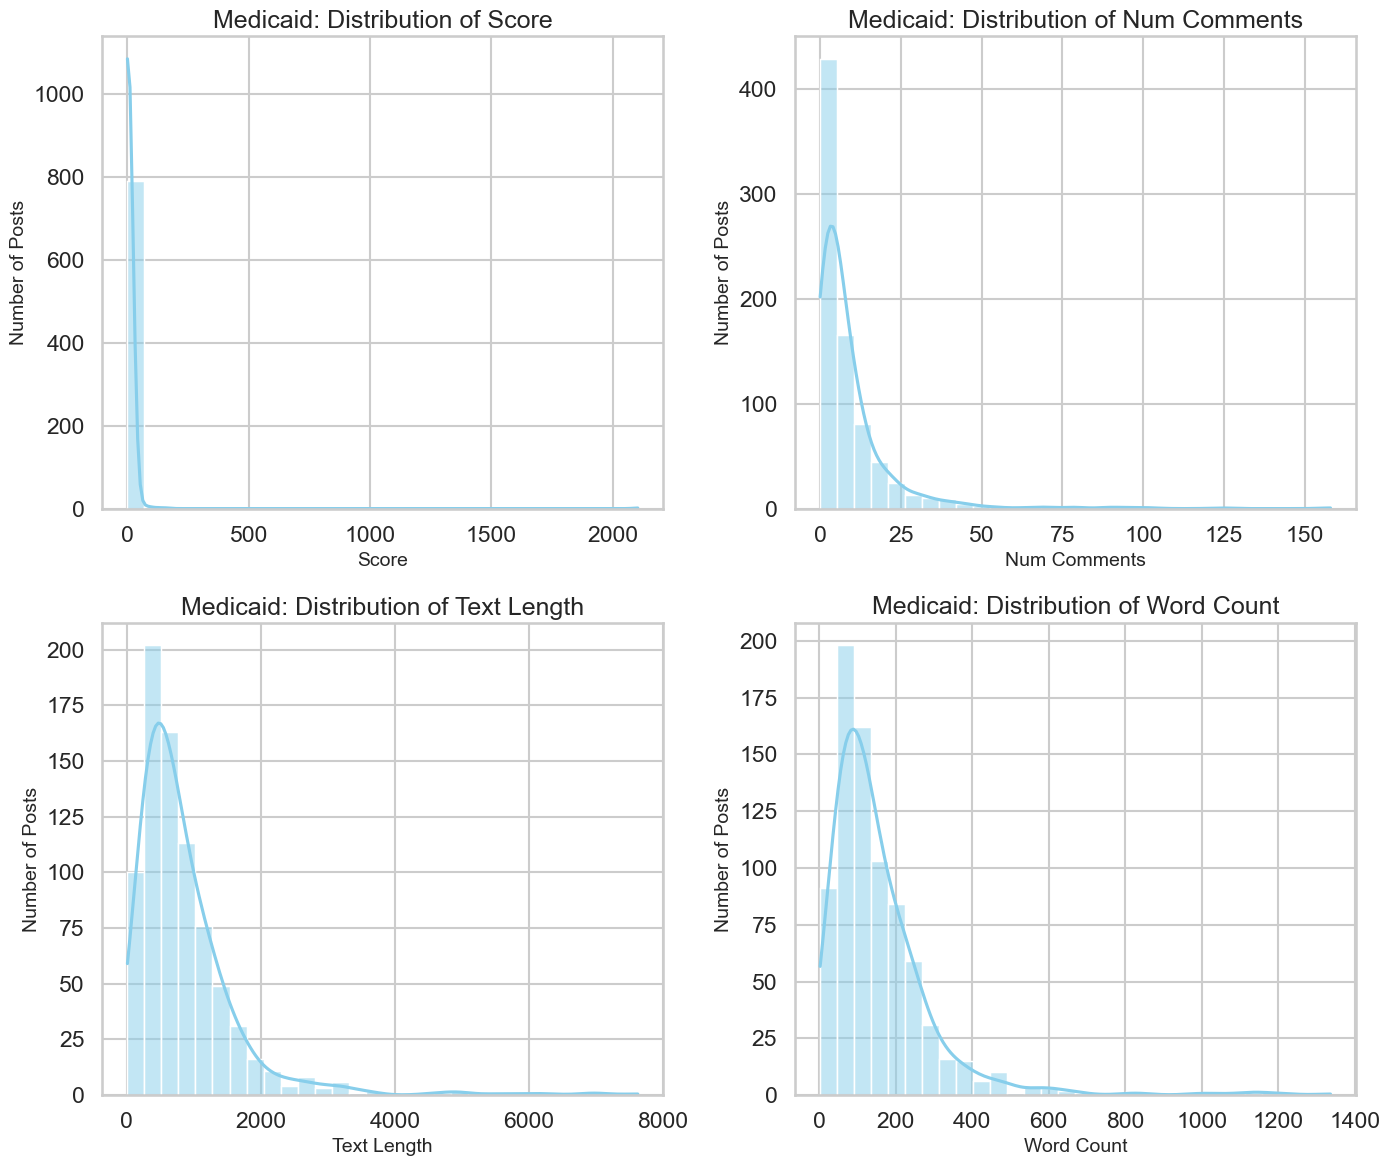

In [16]:
# Medicaid plots 
plot_numeric_distributions(df_medicaid, numeric_cols, program_name="Medicaid")

In [17]:
# Remove outliers using IQR method
df_medicaid, removed_idx_medicaid = remove_outliers(df_medicaid, numeric_cols, method='iqr', threshold=1.5)

# Summary after removal
print(df_medicaid[numeric_cols].describe())

Removed 135 outlier posts (16.98%)
            score  num_comments  text_length  word_count
count  660.000000    660.000000   660.000000  660.000000
mean     2.028788      5.921212   708.954545  129.806061
std      1.494783      5.449158   452.991926   82.952417
min      0.000000      0.000000    10.000000    2.000000
25%      1.000000      2.000000   347.000000   66.000000
50%      2.000000      4.000000   610.500000  110.000000
75%      3.000000      9.000000   998.250000  184.000000
max      6.000000     24.000000  2088.000000  393.000000


### Medicare

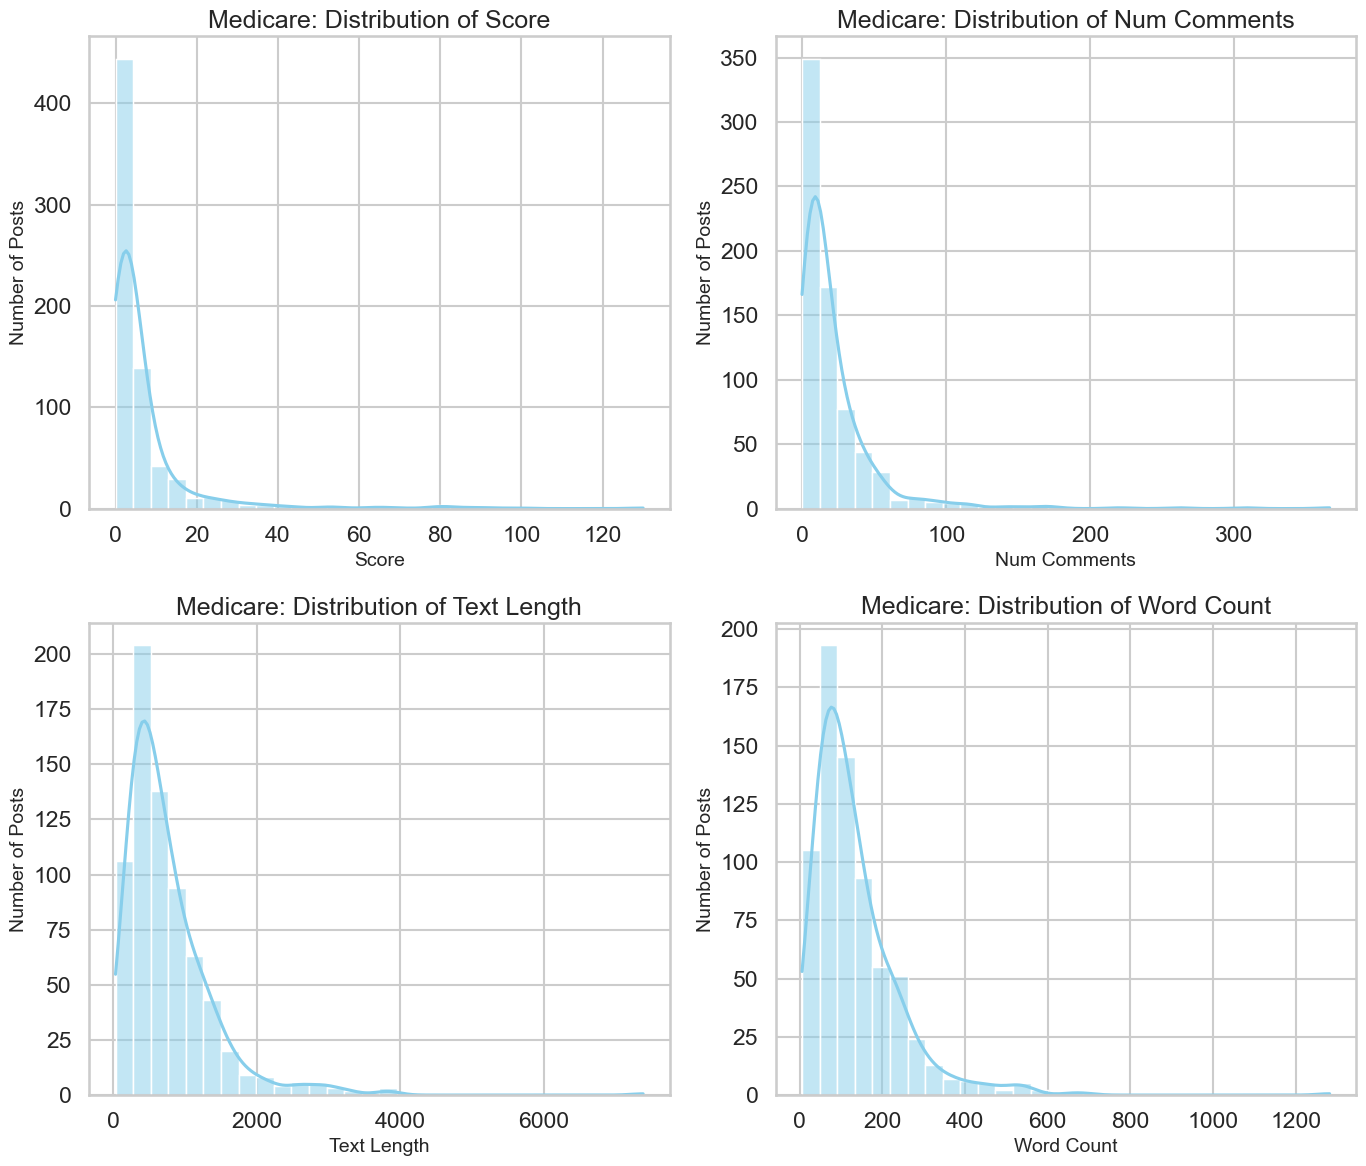

In [18]:
# Medicare plots
plot_numeric_distributions(df_medicare, numeric_cols, program_name="Medicare")

In [19]:
# Remove outliers using IQR method
df_medicare, removed_idx_medicare = remove_outliers(df_medicare, numeric_cols, method='iqr', threshold=1.5)

# Summary after removal
df_medicare[numeric_cols].describe()

Removed 118 outlier posts (16.64%)


,score,num_comments,text_length,word_count
count,591.000000,591.000000,591.000000,591.000000
mean,3.338409,14.077834,641.177665,114.739425
std,2.909458,11.686616,390.950069,69.825398
min,0.000000,0.000000,39.000000,7.000000
25%,1.000000,5.000000,334.500000,61.500000
50%,2.000000,10.000000,544.000000,99.000000
75%,5.000000,19.000000,870.500000,156.500000
max,13.000000,53.000000,1783.000000,328.000000


## TF-IDF

In order to determine the cutoff for `max_df` in our TF-IDF vectorizer, we will investigate the proportion of documents that each token appears in. We will set a baseline `min_df = 10` to focus on words that appear multiple times and are not too specific to a very limited number of posts

In [20]:
def plot_token_doc_frequency(df, text_column="clean_text", program_name="Medicaid", min_df=10):
    """
    Plots distribution of token document frequencies for a given program.
    """
    texts = df[text_column].tolist()
    
    # CountVectorizer to get raw counts
    count_vect = CountVectorizer(stop_words='english', min_df=min_df)
    X_counts = count_vect.fit_transform(texts)
    
    # Document frequency for each token
    doc_freq = (X_counts > 0).sum(axis=0).A1  # number of posts each token appears in
    num_posts = len(texts)
    
    # Convert to proportion
    doc_freq_prop = doc_freq / num_posts
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.histplot(doc_freq_prop, bins=50, color='lightcoral')
    plt.title(f"{program_name}: Distribution of Token Document Frequencies", fontsize=18)
    plt.xlabel("Proportion of Posts Token Appears In", fontsize=14)
    plt.ylabel("Number of Tokens", fontsize=14)
    plt.tight_layout()
    
    # Save figure
    filename = f"{FIGURES_PATH}/{program_name.lower()}_token_doc_freq.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")


### Medicaid

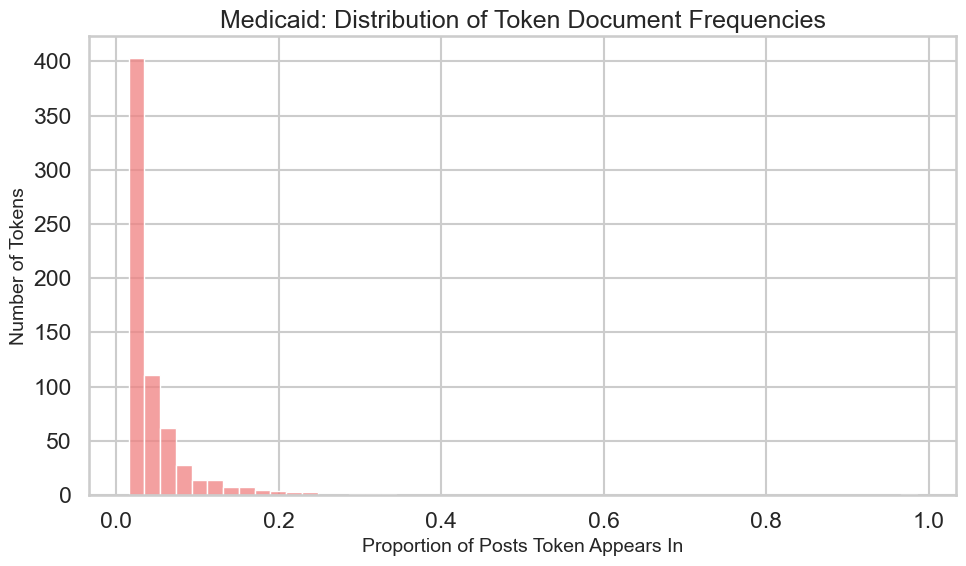

Figure saved as ../figures/medicaid_token_doc_freq.png


In [21]:
plot_token_doc_frequency(df_medicaid, text_column="clean_text", program_name="Medicaid")

Based on the above plot, we will exclude all words appearing in more than 10% of posts.

In [22]:
# Create TFIDF Vectorizer
medicaid_vectorizer = TfidfVectorizer(
    stop_words='english',   # generic English stopwords
    min_df=10,              # word must appear in at least 10 posts
    max_df=0.10,            # remove words appearing in >10% of posts
    ngram_range=(1, 2),     # <-- include unigrams + bigrams
    norm='l2'               # normalize vectors
)

In [23]:
tfidf_matrix_medicaid = medicaid_vectorizer.fit_transform(df_medicaid['clean_text'])

### Medicare

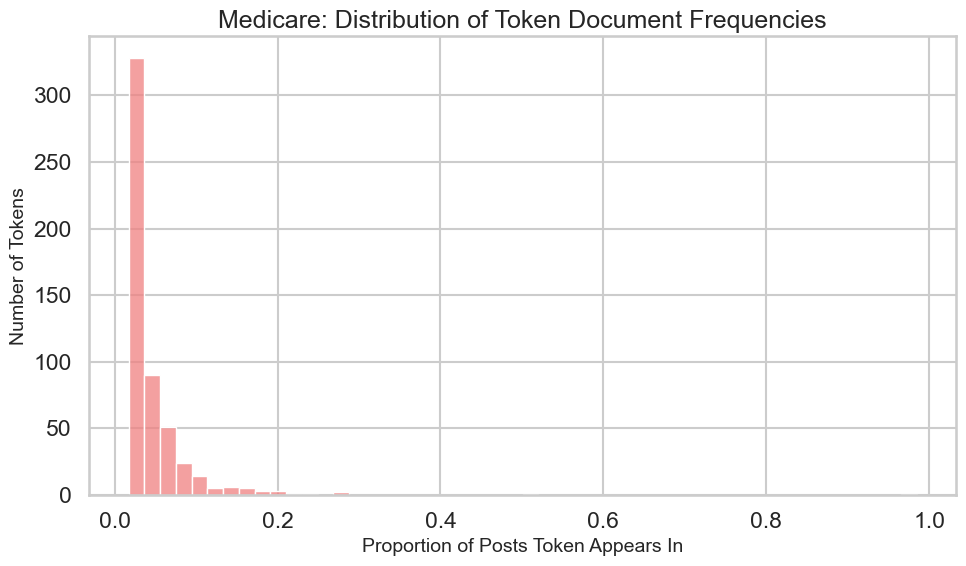

Figure saved as ../figures/medicare_token_doc_freq.png


In [24]:
plot_token_doc_frequency(df_medicare, text_column="clean_text", program_name="Medicare")

Based on the above plot, we will exclude all words appearing in more than 10% of posts.

In [25]:
medicare_vectorizer = TfidfVectorizer(
    stop_words='english',   # generic English stopwords
    min_df=10,              # word must appear in at least 10 posts
    max_df=0.10,            # remove words appearing in >10% of posts
    ngram_range=(1, 2),     # <-- include unigrams + bigrams
    norm='l2'               # normalize vectors
)

In [26]:
tfidf_matrix_medicare = medicare_vectorizer.fit_transform(df_medicare['clean_text'])

## Preprocessing Evaluation

### Medicaid

#### Summary Information

In [27]:
features_medicaid = medicaid_vectorizer.get_feature_names_out()

In [28]:
# Check preprocessing choices
print("Number of posts:", df_medicaid.shape[0])
print("Number of features:", tfidf_matrix_medicaid.shape[1])
print("Sample features:", features_medicaid[:20])

Number of posts: 660
Number of features: 692
Sample features: ['able work' 'aca' 'accept' 'accepted' 'accepts' 'access' 'according'
 'account' 'active' 'actual' 'actually' 'add' 'added' 'address' 'adult'
 'adults' 'advance' 'advantage' 'aetna' 'affect']


#### Sparsity

In [29]:
medicaid_sparsity = 1.0 - (tfidf_matrix_medicaid.nnz / float(tfidf_matrix_medicaid.shape[0] * tfidf_matrix_medicaid.shape[1]))
print("Sparsity:", medicaid_sparsity)

Sparsity: 0.9671790155894202


#### Most and Least Frequent Words

In [30]:
# Examine most frequent words 
idf_medicaid = medicaid_vectorizer.idf_

idf_df_medicaid = pd.DataFrame({'token': features_medicaid, 'idf': idf_medicaid})
idf_df_medicaid.sort_values('idf').head(10)

,token,idf
255,hi,3.289061
494,received,3.304099
498,recently,3.304099
135,covered,3.319367
403,ny,3.319367
83,called,3.334871
287,issues,3.334871
302,letter,3.366619
163,disabled,3.366619
35,applied,3.382880


In [31]:
# Look at least frequent words
idf_df_medicaid.sort_values('idf', ascending=False).head(10)

,token,idf
562,sound,5.095859
489,really know,5.095859
505,remain,5.095859
337,managed,5.095859
111,closed,5.095859
59,aware,5.095859
58,available,5.095859
333,main,5.095859
330,luck,5.095859
310,literally,5.095859


#### IDF Distribution

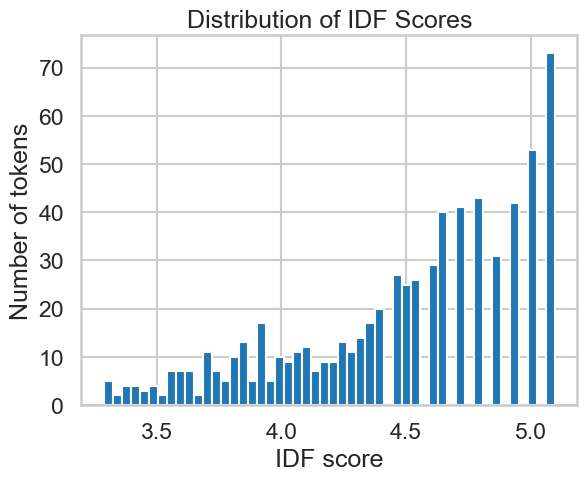

In [32]:
# IDF distribution 
plt.hist(idf_medicaid, bins=50)
plt.xlabel("IDF score")
plt.ylabel("Number of tokens")
plt.title("Distribution of IDF Scores")
plt.show()

In [33]:
mean_tfidf_medicaid = np.asarray(tfidf_matrix_medicaid.mean(axis=0)).ravel()

top_mean_medicaid = pd.DataFrame({
    "term": features_medicaid,
    "mean_tfidf": mean_tfidf_medicaid
}).sort_values("mean_tfidf", ascending=False)

top_mean_medicaid.head(10)


,term,mean_tfidf
403,ny,0.020900
302,letter,0.017099
135,covered,0.016816
163,disabled,0.016442
507,renewal,0.015867
374,mom,0.015596
612,texas,0.015361
292,kids,0.015242
134,cover,0.014949
375,monthly,0.014782


#### Bigrams

In [34]:
# Inspect bigrams from original text
medicaid_counts = Counter()

# Count n-grams in original text
for text in df_medicaid['clean_text']:
    tokens = text.split()
    for w in zip(tokens, tokens[1:]):
        medicaid_counts[" ".join(w)] += 1

print(medicaid_counts.most_common(20))

[('health insurance', 63), ('medi cal', 52), ('social security', 50), ('nursing home', 46), ('long term', 43), ('income limit', 40), ('qualify medicaid', 38), ('medicaid coverage', 37), ('get medicaid', 36), ('even though', 36), ('anyone know', 36), ('medicaid application', 32), ('full time', 31), ('medicaid eligibility', 31), ('monthly income', 31), ('apply medicaid', 29), ('applied medicaid', 29), ('new york', 29), ('year old', 28), ('medicaid medicare', 28)]


In [35]:
# Top bigrams by document frequency 

# Boolean version of TF-IDF matrix (nonzero = term appears in doc)
tfidf_bool_medicaid = (tfidf_matrix_medicaid > 0).astype(int)

# Extract bigrams only
medicaid_bigrams = [t for t in medicaid_vectorizer.get_feature_names_out() if " " in t]

# Compute doc frequency
medicaid_bigram_df = {}
for bg in medicaid_bigrams:
    idx = medicaid_vectorizer.vocabulary_.get(bg)
    medicaid_bigram_df[bg] = int(tfidf_bool_medicaid[:, idx].sum())

# Convert to DataFrame and sort
medicaid_bigram_df = pd.DataFrame(
    sorted(medicaid_bigram_df.items(), key=lambda x: x[1], reverse=True),
    columns=["bigram", "doc_freq"]
)

medicaid_bigram_df.head(10)

,bigram,doc_freq
0,health insurance,51
1,social security,35
2,medicaid coverage,34
3,income limit,32
4,qualify medicaid,32
5,long term,31
6,nursing home,30
7,medicaid application,28
8,apply medicaid,27
9,medicaid eligibility,27


In [36]:
dfreq_medicaid = np.asarray(tfidf_bool_medicaid.sum(axis=0)).ravel()

freq_df_medicaid = pd.DataFrame({"term": features_medicaid, "doc_freq": dfreq_medicaid})
freq_df_medicaid["type"] = np.where(freq_df_medicaid["term"].str.contains(" "), "bigram", "unigram")

freq_df_medicaid.groupby("type")["doc_freq"].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
bigram,81.0,16.864198,7.761690,10.0,11.0,14.0,20.0,51.0
unigram,611.0,22.297872,12.550474,10.0,13.0,18.0,29.0,66.0


#### Empty Documents

In [37]:
# Documents where all TF-IDF entries are zero
empty_docs_mask_medicaid = (tfidf_bool_medicaid.sum(axis=1) == 0).A1

print("Number of empty docs:", empty_docs_mask_medicaid.sum())

Number of empty docs: 0


#### Summary

The TF-IDF analysis for the Medicaid subreddit shows a healthy and interpretable feature set. The vocabulary includes 691 terms, with 610 unigrams and 81 meaningful bigrams, many of which are domain-specific (e.g., "health insurance," "nursing home," "apply medicaid"). The TF-IDF matrix is sparsely populated (96.8%) but contains sufficient signal, with no empty documents. Common unigrams are largely relevant to Medicaid discussions, and no severe noise is present. Given the dimensionality and quality of features, PCA is not necessary at this stage. The current TF-IDF configuration (min_df=10, max_df=0.10, including bigrams, and keeping contractions) is appropriate for clustering. The parameters were chosen based on the distribution of words and the number of features. 

### Medicare

#### Summary Information

In [38]:
medicare_features = medicare_vectorizer.get_feature_names_out()

In [39]:
# Check preprocessing choices
print("Number of posts:", df_medicare.shape[0])
print("Number of features:", tfidf_matrix_medicare.shape[1])
print("Sample features:", medicare_features[:20])

Number of posts: 591
Number of features: 548
Sample features: ['aarp' 'able' 'accept' 'according' 'account' 'actually' 'add' 'added'
 'additional' 'adjustment' 'advance' 'advantage plans' 'advice'
 'advice appreciated' 'aetna' 'afford' 'age' 'agent' 'ago' 'allow']


#### Sparsity

In [40]:
# Check sparsity 
medicare_sparsity = 1.0 - (tfidf_matrix_medicare.nnz / float(tfidf_matrix_medicare.shape[0] * tfidf_matrix_medicare.shape[1]))
print("Sparsity:", medicare_sparsity)

Sparsity: 0.964927069052824


#### Most and Least Frequent Words

In [41]:
# Examine most frequent words 
idf_medicare = medicare_vectorizer.idf_

idf_df_medicare = pd.DataFrame({'token': medicare_features, 'idf': idf_medicare})
idf_df_medicare.sort_values('idf').head(10)

,token,idf
152,employer,3.323064
114,cover,3.323064
308,months,3.323064
67,called,3.340455
273,make,3.358155
283,medicaid,3.358155
473,sure,3.358155
505,trying,3.358155
514,understand,3.358155
489,think,3.376173


In [42]:
# Look at least frequent words
idf_df_medicare.sort_values('idf', ascending=False).head(10)

,token,idf
77,changes,4.985611
450,sorry,4.985611
92,cms,4.985611
91,clear,4.985611
436,showed,4.985611
202,hard,4.985611
325,ok,4.985611
82,cheapest,4.985611
321,ny,4.985611
318,noticed,4.985611


#### IDF Distribution

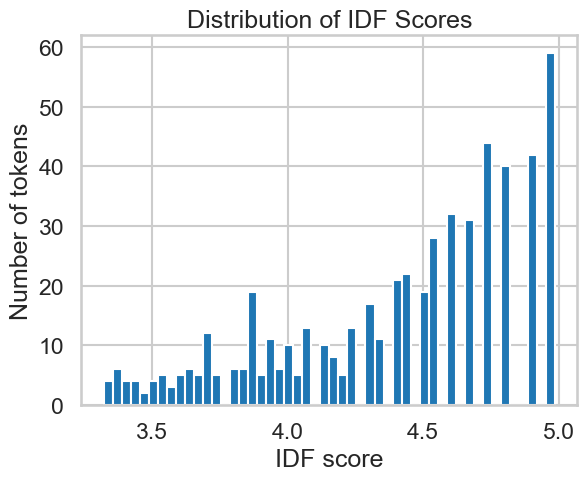

In [43]:
# IDF distribution 
plt.hist(idf_medicare, bins=50)
plt.xlabel("IDF score")
plt.ylabel("Number of tokens")
plt.title("Distribution of IDF Scores")
plt.show()

In [44]:
medicare_mean_tfidf = np.asarray(tfidf_matrix_medicare.mean(axis=0)).ravel()

top_mean_medicare = pd.DataFrame({
    "term": medicare_features,
    "mean_tfidf": medicare_mean_tfidf
}).sort_values("mean_tfidf", ascending=False)

top_mean_medicare.head(10)

,term,mean_tfidf
283,medicaid,0.024473
235,irmaa,0.019750
131,deductible,0.019729
143,drug,0.019447
152,employer,0.018536
73,care,0.017316
114,cover,0.016874
299,medigap plan,0.016779
54,benefits,0.016320
367,premiums,0.016061


#### Bigrams

In [45]:
# Inspect bigrams from original text
medicare_counts = Counter()

# Count n-grams in original text
for text in df_medicare['clean_text']:
    tokens = text.split()
    for w in zip(tokens, tokens[1:]):
        medicare_counts[" ".join(w)] += 1

print(medicare_counts.most_common(20))

[('part b', 207), ('medicare advantage', 152), ('medicare part', 115), ('advantage plan', 100), ('plan g', 78), ('medigap plan', 66), ('social security', 65), ('medicare gov', 49), ('health insurance', 45), ('next year', 42), ('part plan', 40), ('original medicare', 38), ('medicare supplement', 35), ('extra help', 35), ('plan n', 35), ('per month', 31), ('medicare b', 29), ('advantage plans', 29), ('traditional medicare', 28), ('supplement plan', 27)]


In [46]:
# Top bigrams by document frequency 
# Boolean version of TF-IDF matrix (nonzero = term appears in doc)
tfidf_bool_medicare = (tfidf_matrix_medicare > 0).astype(int)

# Extract bigrams only
medicare_bigrams = [t for t in medicare_features if " " in t]

# Compute doc frequency
medicare_bigram_df = {}
for bg in medicare_bigrams:
    idx = medicare_vectorizer.vocabulary_.get(bg)
    medicare_bigram_df[bg] = int(tfidf_bool_medicare[:, idx].sum())

# Convert to DataFrame and sort
medicare_bigram_df = pd.DataFrame(
    sorted(medicare_bigram_df.items(), key=lambda x: x[1], reverse=True),
    columns=["bigram", "doc_freq"]
)

medicare_bigram_df.head(10)

,bigram,doc_freq
0,medigap plan,47
1,medicare gov,41
2,social security,41
3,health insurance,34
4,original medicare,30
5,medicare plan,29
6,medicare supplement,29
7,thanks advance,27
8,open enrollment,25
9,years ago,24


In [47]:
medicare_dfreq = np.asarray(tfidf_bool_medicare.sum(axis=0)).ravel()

medicare_freq_df = pd.DataFrame({"term": medicare_features, "doc_freq": medicare_dfreq})
medicare_freq_df["type"] = np.where(medicare_freq_df["term"].str.contains(" "), "bigram", "unigram")

medicare_freq_df.groupby("type")["doc_freq"].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
bigram,51.0,17.725490,8.919817,10.0,11.0,15.0,21.5,47.0
unigram,497.0,21.036217,11.368227,10.0,13.0,17.0,27.0,57.0


#### Empty Documents

In [48]:
# Documents where all TF-IDF entries are zero
medicare_empty_docs_mask = (tfidf_bool_medicare.sum(axis=1) == 0).A1

print("Number of empty docs:", medicare_empty_docs_mask.sum())

Number of empty docs: 1


In [49]:
# Remove empty docs 
non_empty_mask_medicare = ~medicare_empty_docs_mask
tfidf_matrix_medicare = tfidf_matrix_medicare[non_empty_mask_medicare]
df_medicare = df_medicare[non_empty_mask_medicare].reset_index(drop=True)

print("Shape of TF-IDF matrix after removing empty docs:", tfidf_matrix_medicare.shape)
print("Number of posts after removing empty docs:", df_medicare.shape[0])

Shape of TF-IDF matrix after removing empty docs: (590, 548)
Number of posts after removing empty docs: 590


#### Summary

The TF-IDF analysis for the Medicare subreddit shows a healthy and interpretable feature set. The vocabulary includes 548 terms, with 497 unigrams and 51 meaningful bigrams, many of which are domain-specific (e.g., "health insurance," "nursing home," "apply medicaid"). The TF-IDF matrix is sparsely populated (96.5%) but contains sufficient signal, with only 1 empty document (that have been removed). Common unigrams are largely relevant to Medicare discussions, and no severe noise is present. Given the dimensionality and quality of features, PCA is not necessary at this stage. The current TF-IDF configuration (min_df=10, max_df=0.10, including bigrams, and keeping contractions) is appropriate for clustering. The parameters were chosen based on the distribution of words and the number of features. 

## Export Final Preprocessed Datasets

In [50]:
df_medicare.to_csv("../data/processed_medicare_data.csv", index = False)

In [51]:
df_medicaid.to_csv("../data/processed_medicaid_data.csv", index = False)

In [52]:
save_npz("../data/tfidf_medicare.npz",tfidf_matrix_medicare)

In [53]:
save_npz("../data/tfidf_medicaid.npz",tfidf_matrix_medicaid)

In [54]:
pd.Series(medicaid_vectorizer.get_feature_names_out()).to_csv(
    "../data/medicaid_tfidf_feature_names.csv",
    index=False
)

In [55]:
pd.Series(medicare_vectorizer.get_feature_names_out()).to_csv(
    "../data/medicare_tfidf_feature_names.csv",
    index=False
)